# PyVG: Data Science to predict Video Games sales
>Equipe: Alexis Terrasse, Henri-François Mole, Hsan Drissi, Stephane Lelievre
>
>Promo: DS_Oct21
---
## Essai de classification avec gridsearch et validation croisée
---
<img src="https://files.realpython.com/media/Splitting-Datasets-With-sklearns-train_test_split_Watermarked.e321471660be.jpg" alt="ML Classification" width="500" height="600">

In [1]:
# Importation des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import  GridSearchCV, train_test_split , cross_val_score, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Fonction d'affichage du rapport de classification et Matrice de confusion
def display_results(model,xtest,ytest,oh=False):
    name= type(model).__name__
    y_pred= model.predict(xtest)
    
    if oh:  # Dans le cas d'un model DeepLearning avec one-hot encoding des labels
        name= model._name
        y_pred= np.argmax(y_pred,axis=1)
        ytestoh= to_categorical(ytest, dtype = 'int')
        score= model.evaluate(xtest,ytestoh, verbose= 0)[1]
    else:  # Model de ML classiques
        name= type(model).__name__
        score= model.score(xtest, ytest)
    
    # Calcule du rapport de classification
    clf_report = classification_report(y_pred, ytest, output_dict=True)
    # Calcule de la matrice de confusion
    cnf_matrix= confusion_matrix(y_pred,ytest)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 3]})
    fig.suptitle('Résultats du model '+name+' - Accuracy (test): '+str(round(score,2)), fontsize=15)

    # Affichage du Classification report
    sns.heatmap( pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap= 'GnBu', cbar=False,ax=axes[0])
    axes[0].set_title('Rapport de classification')

    # Affichage de Confusion matrix
    s= sns.heatmap(cnf_matrix, annot=True, fmt=".0f",cmap= "rocket_r",ax=axes[1]) 
    s.set(xlabel='Score prédit', ylabel='Score réel')
    axes[1].set_title('Matrice de confusion')
    # Sauvegarde de la figure
    filename= name+'_'+'acc_'+str(round(score,2))+'.png'
    plt.savefig(filename)

### Read dataset

In [3]:
df = pd.read_csv("../data/vgsales_eda2_ready.csv", sep=",")
print ('Input shape',df.shape)
df.head()
# Input shape (8478, 85)

Input shape (8478, 96)


,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,...,genre_Visual+Novel,labels,labels_0,labels_1,labels_2,labels_3,labels_4,labels_5,labels_6,labels_7
0,Grand Theft Auto: San Andreas,XB,Action,1.95,grand-theft-auto-san-andreas,Grand Theft Auto: San Andreas,"Action Adventure, Modern",9.3,8.8,rockstar games,...,0,4,0,0,0,0,1,0,0,0
1,Grand Theft Auto: San Andreas,PC,Action,0.97,grand-theft-auto-san-andreas,Grand Theft Auto: San Andreas,"Action Adventure, Modern, Modern, Open-World",9.3,8.9,rockstar games,...,0,5,0,0,0,0,0,1,0,0
2,Grand Theft Auto: Vice City,PC,Action,0.04,grand-theft-auto-vice-city,Grand Theft Auto: Vice City,"Action Adventure, Modern, Modern, Open-World",9.4,8.8,rockstar games,...,0,5,0,0,0,0,0,1,0,0
3,Grand Theft Auto III,PC,Action,0.01,grand-theft-auto-iii,Grand Theft Auto III,"Action Adventure, Modern, Modern, Open-World",9.3,8.2,rockstar games,...,0,5,0,0,0,0,0,1,0,0
4,Grand Theft Auto IV,PC,Action,0.87,grand-theft-auto-iv,Grand Theft Auto IV,"Action Adventure, Modern, Modern, Open-World",9.0,7.0,rockstar games,...,0,1,0,1,0,0,0,0,0,0


In [4]:
# Séparer les variables explicatives de la variable à prédire
bins=8
target = pd.qcut(df['Global_Sales'],q=bins, labels=[i for i in range(0,bins)]).astype('int64')

# on retire lea variables à predire, celles inutiles et celles non numeriques
data = df.select_dtypes(exclude='object').drop(['Global_Sales','Global_Sales.log','year','labels',
                                               #'day', 'year', 'month', 'quarter', 'anom',
                                               ],axis=1)

# Séparer le jeu de données en données d'entraînement et données test 
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=0)


In [5]:
# Etape de preprocessing pour normaliser les données
scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
model1 = LogisticRegression (random_state=122, max_iter=2000)
model2 = RandomForestClassifier (random_state=122)
model3 = SVC(random_state=122)
model4 = KNeighborsClassifier()
model5 = DecisionTreeClassifier(random_state=122)


param_grid_lr = {  #'solver': ['liblinear', 'lbfgs'],
                 'C': [0.01, 0.1, 1 ]}

param_grid_rf = [{'n_estimators': [10, 50, 100] }] #,
                #  'min_samples_leaf': [1, 3, 5]}]

param_grid_svc = [{'kernel': ['rbf', 'linear'], # , 'sigmoid'],
                   'C': [0.1, 1, 10]} ] #, 30] }]

param_grid_knn = { 'n_neighbors': np.arange(2,10) }

param_grid_dtc = { 'criterion': ['gini','entropy'],
                  'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150] }


In [7]:
# instanciation des gridsearch, avec la metrique accuracy
gridcvs = {}

for pgrid, clf, name in zip((param_grid_lr, param_grid_rf, param_grid_svc, param_grid_knn, param_grid_dtc),
                            (model1, model2, model3, model4, model5),
                            ('LogisticRegression', 'RF' , 'SVM', 'KNN', "Decistion tree")):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True, scoring ='accuracy')
    gridcvs[name] = gcv

In [8]:
# Validation croisée avec 3 folds (StratifiedKFold)
cv = StratifiedKFold(n_splits=3, shuffle=True)

In [9]:
model_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_train_scaled, y_train, cv=cv)
    model_scores[name] = nested_score
    print(f'{name}: accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

LogisticRegression: accuracy 34.72 +/- 0.40
RF: accuracy 39.69 +/- 0.17
SVM: accuracy 37.72 +/- 1.49
KNN: accuracy 30.48 +/- 0.85
Decistion tree: accuracy 33.34 +/- 0.53


In [10]:
# Selection du modeèle et entrainement
from sklearn.metrics import accuracy_score

final_model = gridcvs['RF']
final_model.fit(X_train_scaled, y_train)

print(f'Best Parameters: {final_model.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_model.predict(X_train_scaled))
test_acc = accuracy_score(y_true=y_test, y_pred=final_model.predict(X_test_scaled))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'n_estimators': 100}
Training Accuracy: 100.00
Test Accuracy: 41.16


In [11]:
# matrice de confusion à partir de ces prédictions
y_pred = final_model.predict(X_test_scaled)         # PREDICT GRID
print('score:' , final_model.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])


score: 0.4115566037735849


Classe prédite,0,1,2,3,4,5,6,7
Classe réelle,,,,,,,,
0,159,26,30,8,7,1,2,2
1,50,44,46,17,3,3,6,3
2,27,27,86,34,10,9,8,6
3,9,18,50,50,28,17,19,1
4,14,14,28,32,43,26,22,6
5,5,10,27,23,29,69,50,34
6,4,2,17,8,19,35,91,55
7,4,1,9,9,7,8,33,156


              precision    recall  f1-score   support

           0       0.58      0.68      0.63       235
           1       0.31      0.26      0.28       172
           2       0.29      0.42      0.34       207
           3       0.28      0.26      0.27       192
           4       0.29      0.23      0.26       185
           5       0.41      0.28      0.33       247
           6       0.39      0.39      0.39       231
           7       0.59      0.69      0.64       227

    accuracy                           0.41      1696
   macro avg       0.39      0.40      0.39      1696
weighted avg       0.40      0.41      0.40      1696



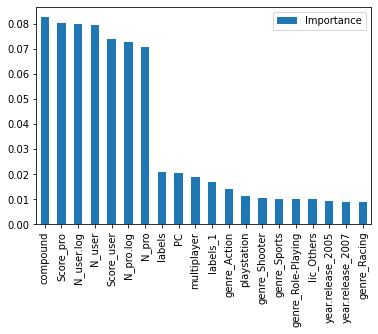

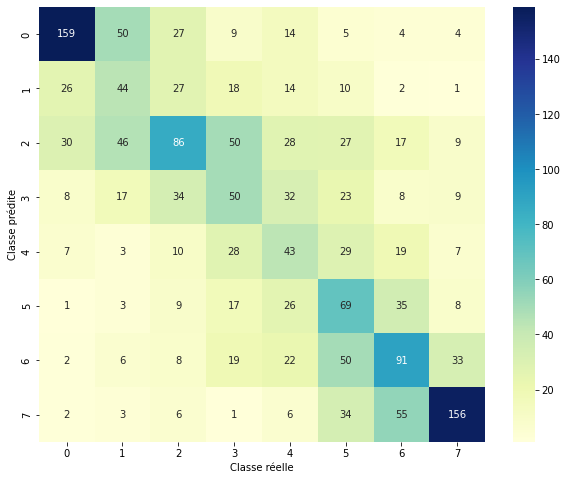

In [12]:
feats = {}
for feature, importance in zip(data.columns, final_model.best_estimator_.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats , orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(20).plot.bar();

# Calcul et affichage de classification_report
print( classification_report(y_test, y_pred) )
#sns.heatmap( pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap= 'GnBu', cbar=False,ax=axes[0])

# Calcul et affichage de la matrice de confusion
contingency_matrix  = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(contingency_matrix.T, annot=True, fmt ='d',cmap="YlGnBu", cbar=True, ax=ax);

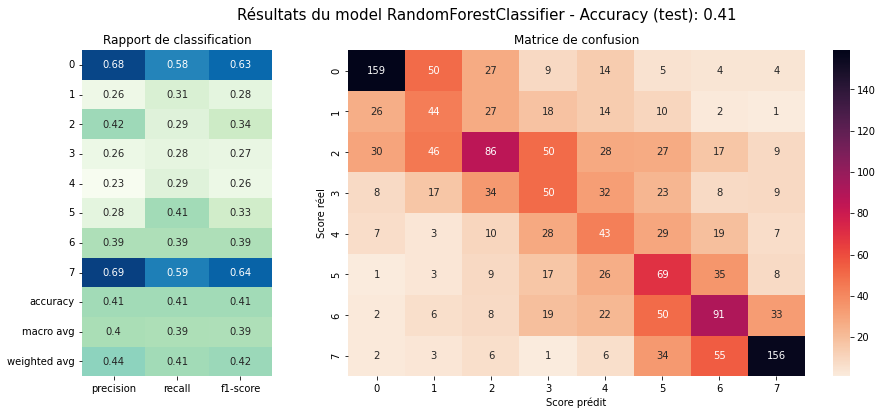

In [13]:
#Même affichage mais plus homogène pour le rapport
display_results(final_model.best_estimator_,X_test_scaled, y_test)